In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
sns.set(font='SimHei',style='whitegrid')  #Seaborn中文显示问题和设置风格 

In [3]:
data = pd.read_excel('H:/数据/ksci数据集/fbsptmsj6834/某厂商旗舰店脱敏数据.xlsx',index_col=0)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76 entries, 0 to 75
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   名称      76 non-null     object 
 1   价格      76 non-null     float64
 2   总销量     76 non-null     int64  
 3   评价数     76 non-null     int64  
 4   MTD     76 non-null     int64  
 5   预估月销量   76 non-null     int64  
 6   6月销量    76 non-null     int64  
 7   预估交易增幅  76 non-null     float64
dtypes: float64(2), int64(5), object(1)
memory usage: 5.3+ KB


In [5]:
data.head()

,名称,价格,总销量,评价数,MTD,预估月销量,6月销量,预估交易增幅
0,常态0,15.9,77424,18225,2365,3666,3814,-0.038804
1,常态1,19.9,122747,29459,1061,1645,1627,0.011063
2,常态2,29.9,21851,5214,1672,2592,2607,-0.005754
3,常态3,16.9,19012,4155,4185,6487,3413,0.900674
4,常态4,19.9,669466,115547,10000,15500,17976,-0.137739


# 分析

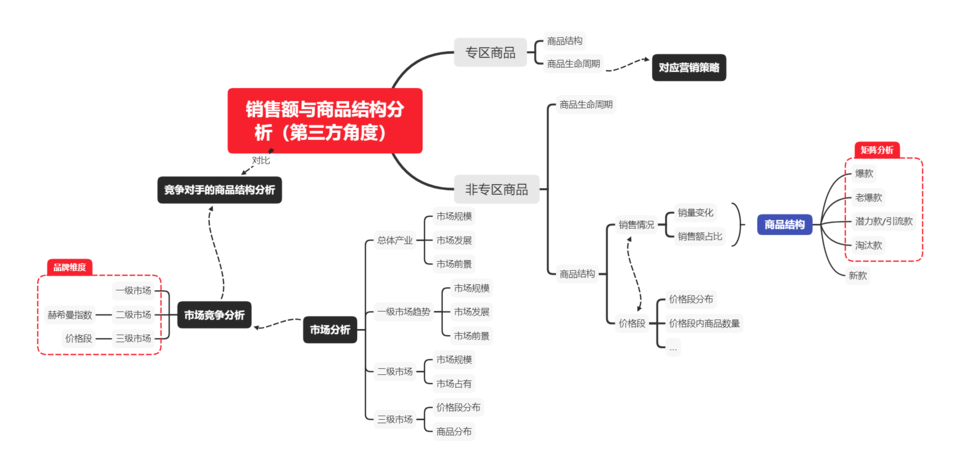

相关说明：

为什么以专区+非专区划分销售额？

销售额可以分析的方向很多。比如从因子树的思路，流量转化客单价；比如结构树的思路，会员+非会员，活动+非活动，总销-退款；比如传统营销的思路，人货场、4P、2W1H......作为无关方（第三方），与能够接触到的公开数据最契合的即是结构树的思路。
矩阵分析为何使用销量变化和销售额占比？

销量变化反应的是市场反响，销售额占比反应的是营收情况。矩阵分解要求维度间不能共线或者高度相关，业务逻辑上也要求不重不漏。
进一步细化思路？

nlp处理产品，使之成为关键词的集合，从而挖掘哪些关键词更受搜索引擎和客户青睐——seo优化,或者考虑itemCF推荐（仅限自有平台）
nlp处理评论数据，根据用户评论刻画用户反馈中产品形象——基于用户评论的产品画像（考虑到可能存在的好评返现活动，可能并不是那么有效）
提供更多数据，量化用户心理值，探寻影响用户购买行为的因素中购买体验起到的作用——量化心理值说（最近看了一篇推文讲的这个，不清楚是否真的有效，但可以用强解释性模型从历史数据进行规则归因）
提供更多数据，从多个方法论出发，综合相关结论(时间成本超级加倍)

# 特征衍生与商品拆分(结构树)

In [6]:
data.head()

,名称,价格,总销量,评价数,MTD,预估月销量,6月销量,预估交易增幅
0,常态0,15.9,77424,18225,2365,3666,3814,-0.038804
1,常态1,19.9,122747,29459,1061,1645,1627,0.011063
2,常态2,29.9,21851,5214,1672,2592,2607,-0.005754
3,常态3,16.9,19012,4155,4185,6487,3413,0.900674
4,常态4,19.9,669466,115547,10000,15500,17976,-0.137739


In [7]:
data['预估交易金额'] = data['预估月销量'] * data['价格']

In [8]:
data.head()

,名称,价格,总销量,评价数,MTD,预估月销量,6月销量,预估交易增幅,预估交易金额
0,常态0,15.9,77424,18225,2365,3666,3814,-0.038804,58289.4
1,常态1,19.9,122747,29459,1061,1645,1627,0.011063,32735.5
2,常态2,29.9,21851,5214,1672,2592,2607,-0.005754,77500.8
3,常态3,16.9,19012,4155,4185,6487,3413,0.900674,109630.3
4,常态4,19.9,669466,115547,10000,15500,17976,-0.137739,308450.0


In [9]:
data['预估交易占比'] = data.预估交易金额/sum(data.预估交易金额)

In [10]:
data.head()

,名称,价格,总销量,评价数,MTD,预估月销量,6月销量,预估交易增幅,预估交易金额,预估交易占比
0,常态0,15.9,77424,18225,2365,3666,3814,-0.038804,58289.4,0.038265
1,常态1,19.9,122747,29459,1061,1645,1627,0.011063,32735.5,0.021490
2,常态2,29.9,21851,5214,1672,2592,2607,-0.005754,77500.8,0.050877
3,常态3,16.9,19012,4155,4185,6487,3413,0.900674,109630.3,0.071969
4,常态4,19.9,669466,115547,10000,15500,17976,-0.137739,308450.0,0.202488


In [11]:
# 考虑到店铺新品的关系，可能存在增幅高而实际销量低的产品，将其筛选出来
data.预估交易增幅.describe(percentiles=[i/100 for i in range(0,100,5)])

count    76.000000
mean      0.317176
std       1.086784
min      -0.731707
0%       -0.731707
5%       -0.087587
10%      -0.043499
15%      -0.009170
20%      -0.003356
25%       0.000000
30%       0.000000
35%       0.000000
40%       0.000000
45%       0.011857
50%       0.017072
55%       0.022257
60%       0.047619
65%       0.054825
70%       0.064860
75%       0.258929
80%       0.454545
85%       0.550907
90%       0.650779
95%       1.108696
max       7.875000
Name: 预估交易增幅, dtype: float64

In [12]:
data[data.预估交易增幅>1]
#查看下异常值，发现都是专区开头的新产品

,名称,价格,总销量,评价数,MTD,预估月销量,6月销量,预估交易增幅,预估交易金额,预估交易占比
32,专区32,3.5,45,11,46,71,8,7.875000,248.5,0.000163
36,专区36,5.7,28,9,36,56,23,1.434783,319.2,0.000210
41,专区41,6.2,15,7,14,22,8,1.750000,136.4,0.000090
66,专区66,10.0,14,1,15,23,4,4.750000,230.0,0.000151


In [13]:
# 将专区和常规商品分类
data['专区'] = data['名称'].str.contains('专区')+0  # 显示为0 1 

In [14]:
data.head()

,名称,价格,总销量,评价数,MTD,预估月销量,6月销量,预估交易增幅,预估交易金额,预估交易占比,专区
0,常态0,15.9,77424,18225,2365,3666,3814,-0.038804,58289.4,0.038265,0
1,常态1,19.9,122747,29459,1061,1645,1627,0.011063,32735.5,0.021490,0
2,常态2,29.9,21851,5214,1672,2592,2607,-0.005754,77500.8,0.050877,0
3,常态3,16.9,19012,4155,4185,6487,3413,0.900674,109630.3,0.071969,0
4,常态4,19.9,669466,115547,10000,15500,17976,-0.137739,308450.0,0.202488,0


In [15]:
data.groupby('专区')['预估交易增幅'].describe()

,count,mean,std,min,25%,50%,75%,max
专区,,,,,,,,
0,49.0,0.035274,0.164354,-0.137739,-0.003922,0.000000,0.023810,0.900674
1,27.0,0.828775,1.713354,-0.731707,0.053881,0.454545,0.602011,7.875000


In [16]:
data.groupby('专区')['预估交易占比'].sum()

专区
0    0.992559
1    0.007441
Name: 预估交易占比, dtype: float64

虽然专区商品在交易占比中占比很小，但其交易增幅与老产品存在明显不同，可以作为销售额突破的备选方向。

建议追加更多数据，以探究当前交易占比低下的原因（渠道流量原因/市场需求原因/企业宣传原因/产品结构原因），从而确定如何投入资源。

# 专区商品结构探究

In [17]:
zhuanqu = data[data.专区==1]

In [18]:
zhuanqu.head()

,名称,价格,总销量,评价数,MTD,预估月销量,6月销量,预估交易增幅,预估交易金额,预估交易占比,专区
24,专区24,6.8,291,7,216,335,228,0.469298,2278.0,0.001495,1
25,专区25,5.7,35,10,13,20,16,0.250000,114.0,0.000075,1
32,专区32,3.5,45,11,46,71,8,7.875000,248.5,0.000163,1
35,专区35,7.0,132,5,87,135,105,0.285714,945.0,0.000620,1
36,专区36,5.7,28,9,36,56,23,1.434783,319.2,0.000210,1


In [19]:
mean_zq_jyzf = zhuanqu.预估交易增幅.mean()

In [20]:
mean_zq_jyzb = zhuanqu.预估交易占比.mean()

## 专区爆款

定义为 交易增幅高于平均交易增幅 且 交易占比高于平均交易占比 的商品

In [21]:
zhuanqu[(zhuanqu.预估交易增幅>mean_zq_jyzf)&(zhuanqu.预估交易占比>mean_zq_jyzb)]

,名称,价格,总销量,评价数,MTD,预估月销量,6月销量,预估交易增幅,预估交易金额,预估交易占比,专区


在专区商品中，并无相应的爆款产品。其原因可能是专区商品上架不久，产品仍处于较低的生命周期层次；市场对其认知与曝光有限；也可能是宣发策略存在问题；抑或是商品与流量来源需求存在不匹配。

建议追加相关商品的流量数据进行探究。

商品上架不久，产品仍处于较低的生命周期层次中 对应 商品商家时间距今周数

曝光有限 对应 UV、PV 低走

宣发策略存在问题 对应 uv低而pv高（可能存在刷访问量）

渠道流量与产品不匹配 对应 渠道广告页面跳失率居高不下

宣发素材存在问题 对应 页面停留时间较低

考虑到专区产品大部分可能处于较低的生命周期层次，尝试通过聚类算法将其进行区分（因为在产品生命周期中，这部分商品都应归于导入期，这里尝试能否通过聚类将其进行更细粒度的区分）

注意，这里聚类的含义是，同簇的产品在导入期内的表现相似，并非商品特征相似

## 使用聚类算法对专区商品进行聚类

- 尝试使用聚类来将专区产品分组.考虑到产品销售情况很有可能是球形簇，直接使用kmeans进行聚类
- 发现kmean聚类效果其实并不理想，换用更适宜小样本的谱聚类
- 聚类算法基本假设：样本空间中的两个点越相近越相似
- 即：参与聚类的特征的取值越相近，则认为两个商品的生命周期层次越相似。

In [22]:
from sklearn.cluster import KMeans,SpectralClustering
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import silhouette_score

特征选择

- 名称 删去
- 价格 归一化
- 评价数 归一化
- 总销量、预估月销量、六月销量、预估交易增幅，前两者派生出第三者，考虑删除六月销量以防止多重共线性加重特征权重，并将预估交易增幅标准化
    - 通过查看相关性发现，总销量和预估月销量、六月销量存在高度相关，说明产品可能只上架了两三个月
    - 决定保留总销量和交易增幅
- 预估交易金额、预估交易占比 存在线性关系，考虑删除预估交易金额

综上，我们保留价格、总销量、评价数、预估交易增幅和预估交易占比五个维度
- 价格、总销量、评价数、预估交易占比 、MinMaxScaler进行归一化
- 预估交易增幅 有正有负，而且存在离群值，考虑进行StandardScaler

In [23]:
zhuanqu.head()

,名称,价格,总销量,评价数,MTD,预估月销量,6月销量,预估交易增幅,预估交易金额,预估交易占比,专区
24,专区24,6.8,291,7,216,335,228,0.469298,2278.0,0.001495,1
25,专区25,5.7,35,10,13,20,16,0.250000,114.0,0.000075,1
32,专区32,3.5,45,11,46,71,8,7.875000,248.5,0.000163,1
35,专区35,7.0,132,5,87,135,105,0.285714,945.0,0.000620,1
36,专区36,5.7,28,9,36,56,23,1.434783,319.2,0.000210,1


In [24]:
zhuanqu.corr()

,价格,总销量,评价数,MTD,预估月销量,6月销量,预估交易增幅,预估交易金额,预估交易占比,专区
价格,1.000000,-0.282254,-0.530777,-0.305195,-0.305604,-0.273429,-0.292532,-0.192725,-0.192725,NaN
总销量,-0.282254,1.000000,0.321226,0.977702,0.977606,0.974425,-0.042894,0.897316,0.897316,NaN
评价数,-0.530777,0.321226,1.000000,0.318376,0.317547,0.224668,0.346329,0.142749,0.142749,NaN
MTD,-0.305195,0.977702,0.318376,1.000000,0.999993,0.959396,0.053654,0.924096,0.924096,NaN
预估月销量,-0.305604,0.977606,0.317547,0.999993,1.000000,0.959524,0.052353,0.924264,0.924264,NaN
6月销量,-0.273429,0.974425,0.224668,0.959396,0.959524,1.000000,-0.175773,0.932767,0.932767,NaN
预估交易增幅,-0.292532,-0.042894,0.346329,0.053654,0.052353,-0.175773,1.000000,-0.094788,-0.094788,NaN
预估交易金额,-0.192725,0.897316,0.142749,0.924096,0.924264,0.932767,-0.094788,1.000000,1.000000,NaN
预估交易占比,-0.192725,0.897316,0.142749,0.924096,0.924264,0.932767,-0.094788,1.000000,1.000000,NaN
专区,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 相关性筛选特征

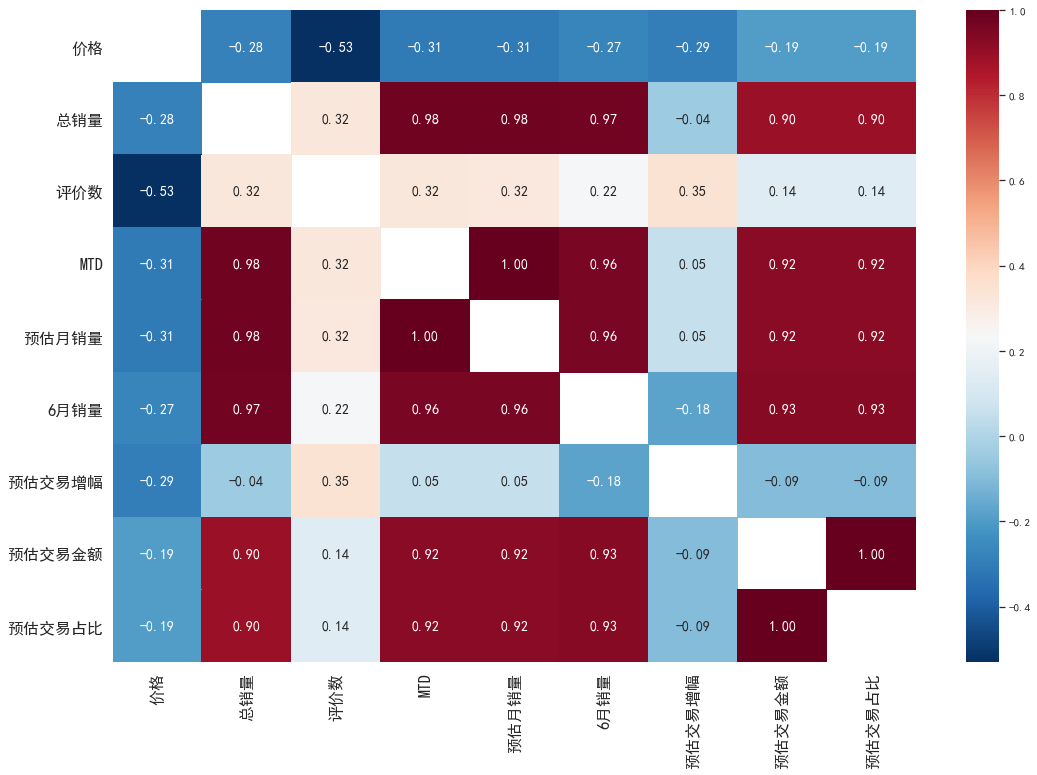

In [25]:
plt.figure(figsize=(18, 12),)
sns.heatmap(zhuanqu.drop(['名称','专区'],axis=1).corr(), cmap='RdBu_r', annot=True, fmt='.2f',annot_kws={'fontsize':14},mask=np.eye(9))
plt.tick_params(axis='x',labelsize=16,labelrotation=90)
plt.tick_params(axis='y',labelsize=16,labelrotation=360)

In [26]:
x = zhuanqu[['价格','总销量','评价数','预估交易占比','预估交易增幅']]
x.head()

,价格,总销量,评价数,预估交易占比,预估交易增幅
24,6.8,291,7,0.001495,0.469298
25,5.7,35,10,0.000075,0.250000
32,3.5,45,11,0.000163,7.875000
35,7.0,132,5,0.000620,0.285714
36,5.7,28,9,0.000210,1.434783


### 归一化

In [27]:
for i in x.columns[:-1]:
    x[[i]] = MinMaxScaler().fit_transform(x[[i]])

<ipython-input-27-a3d98d467a09>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[[i]] = MinMaxScaler().fit_transform(x[[i]])
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
<ipython-input-27-a3d98d467a09>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [28]:
x.head()

,价格,总销量,评价数,预估交易占比,预估交易增幅
24,0.095652,1.000000,0.636364,1.000000,0.469298
25,0.063768,0.117241,0.909091,0.050044,0.250000
32,0.000000,0.151724,1.000000,0.109087,7.875000
35,0.101449,0.451724,0.454545,0.414838,0.285714
36,0.063768,0.093103,0.818182,0.140123,1.434783


### 标准化

In [29]:
x[['预估交易增幅']] = StandardScaler().fit_transform(x[['预估交易增幅']])

<ipython-input-29-72f2eb67077a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[['预估交易增幅']] = StandardScaler().fit_transform(x[['预估交易增幅']])
D:\Anaconda\lib\site-packages\pandas\core\frame.py:2969: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:2935: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

### 聚类模型

In [30]:
score = pd.Series()

<ipython-input-30-f32218d99a2b>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  score = pd.Series()


In [31]:
k_list = [i for i in range(2,15)]   # 构造聚类参数列表

[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[2 2 1 2 2 2 0 2 2 0 2 0 2 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 3 0 0 2 2 2]
[0 4 1 0 4 0 0 4 0 0 0 0 4 0 0 0 2 0 0 0 0 3 0 0 2 2 2]
[5 0 2 1 0 1 1 0 1 1 1 1 0 1 1 1 4 1 1 1 1 3 1 1 4 4 4]
[5 6 0 1 4 1 1 4 1 1 6 6 4 1 1 1 3 1 1 1 1 2 1 1 3 3 3]
[7 6 2 1 0 1 1 0 1 5 6 6 0 5 5 5 3 5 5 1 5 4 5 5 3 3 3]
[6 5 1 4 8 4 4 8 4 0 7 7 5 0 0 0 3 0 0 4 0 2 0 0 3 3 3]
[5 7 1 8 3 8 9 3 8 2 6 6 7 2 2 2 0 2 2 9 2 4 2 2 0 0 0]
[ 7  3  1  5  8  5 10  8  5  0  9  6  3  0  0  0  4  0  0 10  0  2  0  0
  4  4  4]
[ 6  3  1  8  7  8  5  7  8  0 10  9  3  0 11  0  4 11 11  5 11  2  0  0
  4  4  4]
[ 5  4  1  9  6  9 12  6  9 11 10  7  4 11  0 11  3  0  0  8  0  2 11 11
  3  3  3]
[ 4 10  1  2  6  2 11  6  2 13  7  9 12 13  8  0  5  8  8 11 13  3 13 13
  5  5  5]


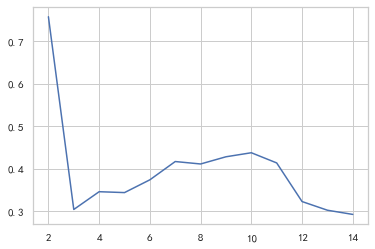

In [32]:
for i in k_list:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(x)
    labels = kmeans.labels_
    print(labels)
    score[str(i)] = silhouette_score(x,labels)
score.plot()

In [33]:
score

2     0.757978
3     0.304041
4     0.345897
5     0.343809
6     0.373919
7     0.416956
8     0.411195
9     0.428158
10    0.437669
11    0.413680
12    0.322718
13    0.302284
14    0.292409
dtype: float64

K =2 时轮廓系数最高，约0.75,查看下具体的参数

In [34]:
kmeans = KMeans(n_clusters = 2)
kmeans.fit(x)
kmeans.cluster_centers_

x['label'] = kmeans.labels_
x_1 = zhuanqu[['价格','总销量','评价数','预估交易占比','预估交易增幅']]
x_1['label'] = kmeans.labels_

<ipython-input-34-977f19d3808d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['label'] = kmeans.labels_
<ipython-input-34-977f19d3808d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_1['label'] = kmeans.labels_


In [35]:
x_1

,价格,总销量,评价数,预估交易占比,预估交易增幅,label
24,6.8,291,7,0.001495,0.469298,1
25,5.7,35,10,0.000075,0.250000,1
32,3.5,45,11,0.000163,7.875000,0
35,7.0,132,5,0.000620,0.285714,1
36,5.7,28,9,0.000210,1.434783,1
38,11.5,72,6,0.000574,0.245902,1
39,11.9,48,1,0.000594,0.041096,1
41,6.2,15,7,0.000090,1.750000,1
43,11.5,53,5,0.000506,0.395833,1
47,11.5,22,1,0.000189,0.562500,1


K=2时，它实际上是把离群点聚为一类，集群点聚为另一类了

这并不一定是我们想要的结果。

对于此，我们有两种思路，一种是对集群点再次尝试聚类，一种是通过其他方法来寻找最佳K值（试了下区间间隔统计，效果也不好。代码较长就不放了）

两个都尝试下

In [37]:
x

,价格,总销量,评价数,预估交易占比,预估交易增幅,label
24,0.095652,1.000000,0.636364,1.000000,-0.213806,1
25,0.063768,0.117241,0.909091,0.050044,-0.344237,1
32,0.000000,0.151724,1.000000,0.109087,4.190874,0
35,0.101449,0.451724,0.454545,0.414838,-0.322995,1
36,0.063768,0.093103,0.818182,0.140123,0.360434,1
38,0.231884,0.244828,0.545455,0.383670,-0.346675,1
39,0.243478,0.162069,0.090909,0.397015,-0.468487,1
41,0.078261,0.048276,0.636364,0.059877,0.547916,1
43,0.231884,0.179310,0.454545,0.338235,-0.257500,1
47,0.231884,0.072414,0.090909,0.126207,-0.158372,1


<ipython-input-38-e07b3d3bdd80>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  score2 = pd.Series()


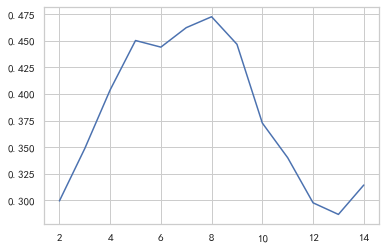

In [38]:
# 单独对集群点进行聚类
x_2 = x[x.label==1]
score2 = pd.Series()
for i in k_list:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(x_2.iloc[:,:-1])
    labels = kmeans.labels_
    score2[str(i)] = silhouette_score(x_2.iloc[:,:-1],labels,metric='euclidean')
score2.plot()

#k=8时 轮廓系数最大，不到0.475。这个轮廓系数在可接受的范围内，但是K值仍然太大了。取5也可以其实。
#事实上，轮廓系数虽然越接近1越好，但实际中高于0.3或0.4就可以接受
#试试组内平方和

In [39]:
def kmeans_sse(x,clusters):
    k = range(1,clusters+1)
    total_sse = []
    for i in k:
        sse = []
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(x)
        labels = kmeans.labels_

        centers = kmeans.cluster_centers_
        
        for label in set(labels):
            sse.append(np.sum((x.loc[labels==label,]-centers[label,:])**2))
                       
        total_sse.append(np.sum(sse))
    plt.plot(k,total_sse,'*-')
    plt.show()

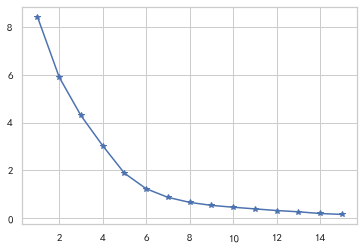

In [40]:
kmeans_sse(x_2[['价格','总销量','评价数','预估交易占比','预估交易增幅']],15)

In [ ]:
kmeans_sse(x_1[['价格','总销量','评价数','预估交易占比','预估交易增幅']],15)

In [41]:
#以上两种思路结果其实并不是很理想。我们尝试换一种聚类方法
x_3 = x.drop(['label'],axis=1).copy()

In [42]:
x_3

,价格,总销量,评价数,预估交易占比,预估交易增幅
24,0.095652,1.000000,0.636364,1.000000,-0.213806
25,0.063768,0.117241,0.909091,0.050044,-0.344237
32,0.000000,0.151724,1.000000,0.109087,4.190874
35,0.101449,0.451724,0.454545,0.414838,-0.322995
36,0.063768,0.093103,0.818182,0.140123,0.360434
38,0.231884,0.244828,0.545455,0.383670,-0.346675
39,0.243478,0.162069,0.090909,0.397015,-0.468487
41,0.078261,0.048276,0.636364,0.059877,0.547916
43,0.231884,0.179310,0.454545,0.338235,-0.257500
47,0.231884,0.072414,0.090909,0.126207,-0.158372


<ipython-input-43-e82fb6466cc7>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  score3 = pd.Series()


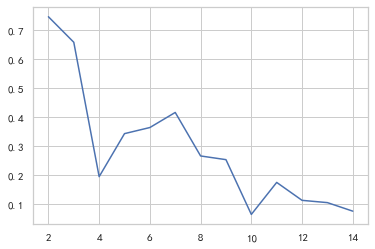

In [43]:
score3 = pd.Series()
for i in k_list:
    kmeans = SpectralClustering(n_clusters=i)
    kmeans.fit(x_3)
    labels = kmeans.labels_
    score3[str(i)] = silhouette_score(x_3,labels,metric='euclidean')
score3.plot()

#谱聚类轮廓系数的次高点是K=3，发现比kmeans还是不错的

In [44]:
sc = SpectralClustering(n_clusters=3)
sc.fit(x[['价格','总销量','评价数','预估交易占比','预估交易增幅']])
sc.labels_

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0])

我们发现K=3的'不错'实际上是把两个离群值各自聚为一类了，我们尝试去掉离群值进行聚类

In [45]:
x_4 = x_2.drop(['label'],axis=1).copy()

<ipython-input-46-f34eefa4e301>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  score4 = pd.Series()


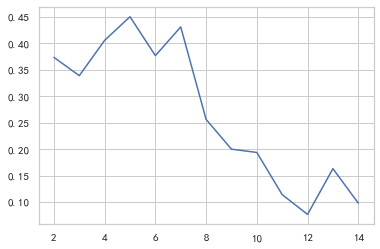

In [46]:
score4 = pd.Series()
for i in k_list:
    sc = SpectralClustering(n_clusters=i)
    sc.fit(x_4)
    labels = sc.labels_
    score4[str(i)] = silhouette_score(x_4,labels,metric='euclidean')
score4.plot()
    

我们经由以上探究，确认可以试着将专区中导入期的商品进行更细粒度的划分，将其划分为新的六类

注意，这里是将两个离群值视为一类，实际上k仍然取7

- 专区商品簇探究
    - 回到我们的分析中来，我们将商品划分为7个簇。抛开离群值，我们探究剩下五个簇的特征。

In [47]:
x = zhuanqu[['价格','总销量','评价数','预估交易占比','预估交易增幅']]
x

,价格,总销量,评价数,预估交易占比,预估交易增幅
24,6.8,291,7,0.001495,0.469298
25,5.7,35,10,0.000075,0.250000
32,3.5,45,11,0.000163,7.875000
35,7.0,132,5,0.000620,0.285714
36,5.7,28,9,0.000210,1.434783
38,11.5,72,6,0.000574,0.245902
39,11.9,48,1,0.000594,0.041096
41,6.2,15,7,0.000090,1.750000
43,11.5,53,5,0.000506,0.395833
47,11.5,22,1,0.000189,0.562500


In [48]:
for i in x.columns[:-1]:
    x[[i]] = MinMaxScaler().fit_transform(x[[i]])
x[['预估交易增幅']] = StandardScaler().fit_transform(x[['预估交易增幅']])

<ipython-input-48-2bce20d8c330>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[[i]] = MinMaxScaler().fit_transform(x[[i]])
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
<ipython-input-48-2bce20d8c330>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [49]:
x

,价格,总销量,评价数,预估交易占比,预估交易增幅
24,0.095652,1.000000,0.636364,1.000000,-0.213806
25,0.063768,0.117241,0.909091,0.050044,-0.344237
32,0.000000,0.151724,1.000000,0.109087,4.190874
35,0.101449,0.451724,0.454545,0.414838,-0.322995
36,0.063768,0.093103,0.818182,0.140123,0.360434
38,0.231884,0.244828,0.545455,0.383670,-0.346675
39,0.243478,0.162069,0.090909,0.397015,-0.468487
41,0.078261,0.048276,0.636364,0.059877,0.547916
43,0.231884,0.179310,0.454545,0.338235,-0.257500
47,0.231884,0.072414,0.090909,0.126207,-0.158372


In [50]:
sc = SpectralClustering(n_clusters=7)
sc.fit(x)
x['labels'] = sc.labels_

<ipython-input-50-6883a720287c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['labels'] = sc.labels_


In [51]:
x

,价格,总销量,评价数,预估交易占比,预估交易增幅,labels
24,0.095652,1.000000,0.636364,1.000000,-0.213806,3
25,0.063768,0.117241,0.909091,0.050044,-0.344237,6
32,0.000000,0.151724,1.000000,0.109087,4.190874,2
35,0.101449,0.451724,0.454545,0.414838,-0.322995,1
36,0.063768,0.093103,0.818182,0.140123,0.360434,5
38,0.231884,0.244828,0.545455,0.383670,-0.346675,1
39,0.243478,0.162069,0.090909,0.397015,-0.468487,1
41,0.078261,0.048276,0.636364,0.059877,0.547916,5
43,0.231884,0.179310,0.454545,0.338235,-0.257500,1
47,0.231884,0.072414,0.090909,0.126207,-0.158372,1


In [52]:
xcen = x.groupby('labels').mean().drop([1,2])
xcen

,价格,总销量,评价数,预估交易占比,预估交易增幅
labels,,,,,
0,0.188406,0.044828,0.090909,0.100966,2.332222
3,0.095652,1.000000,0.636364,1.000000,-0.213806
4,0.910870,0.018966,0.090909,0.038762,-0.492929
5,0.071014,0.070690,0.727273,0.100000,0.454175
6,0.060145,0.103448,0.659091,0.045457,-0.512159


In [53]:
xcen_r = xcen.copy()

In [54]:
xcen_r['价格2'] = xcen_r['价格']

In [55]:
xcen_r

,价格,总销量,评价数,预估交易占比,预估交易增幅,价格2
labels,,,,,,
0,0.188406,0.044828,0.090909,0.100966,2.332222,0.188406
3,0.095652,1.000000,0.636364,1.000000,-0.213806,0.095652
4,0.910870,0.018966,0.090909,0.038762,-0.492929,0.910870
5,0.071014,0.070690,0.727273,0.100000,0.454175,0.071014
6,0.060145,0.103448,0.659091,0.045457,-0.512159,0.060145


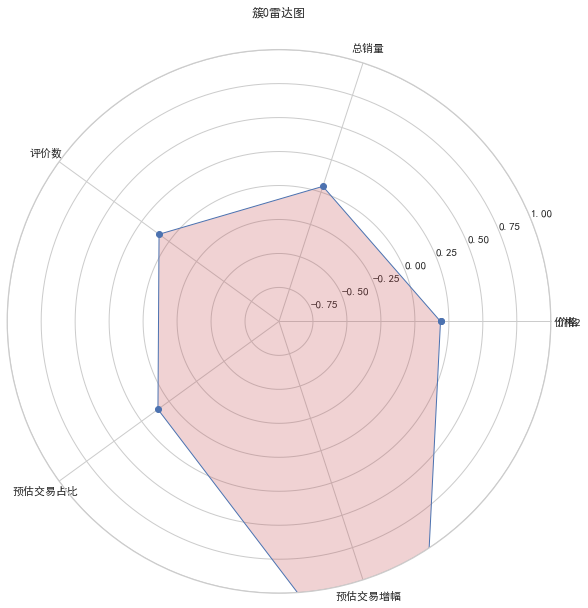

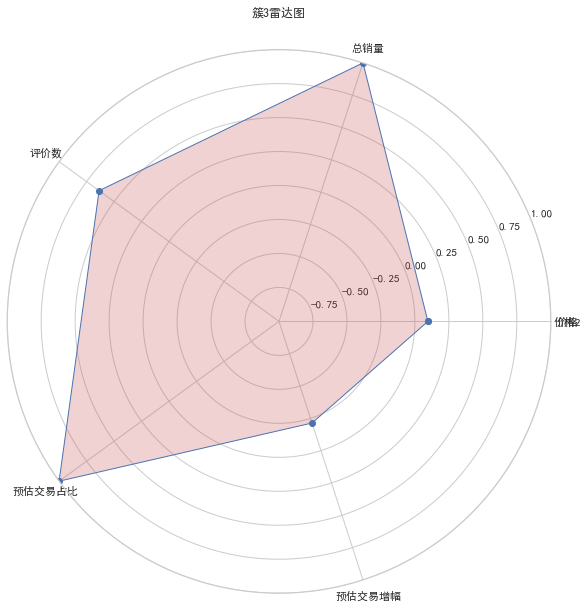

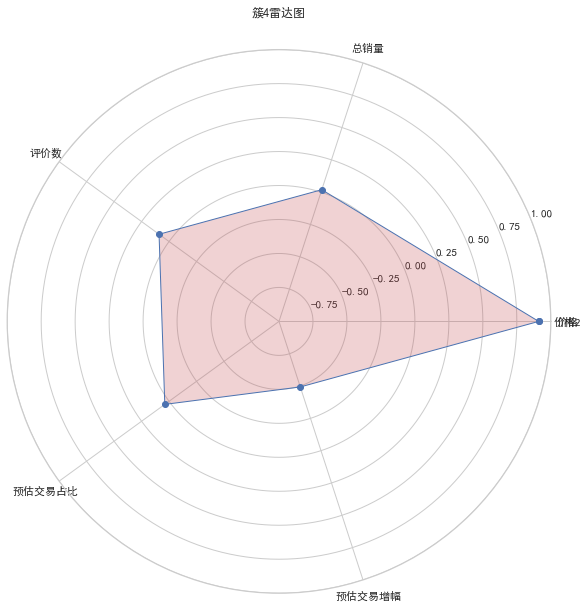

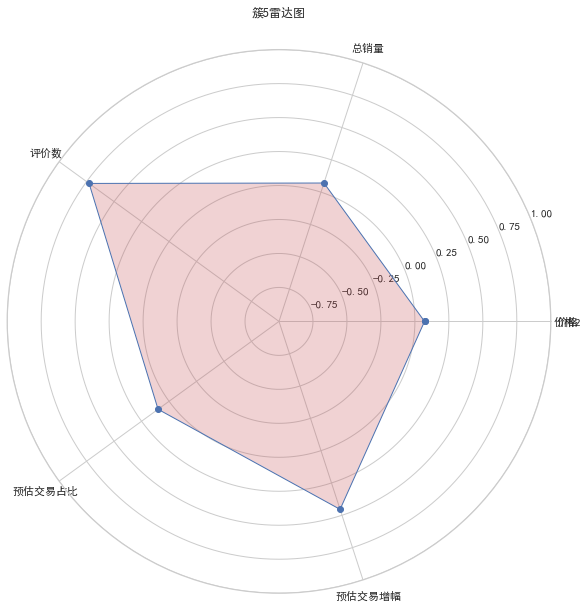

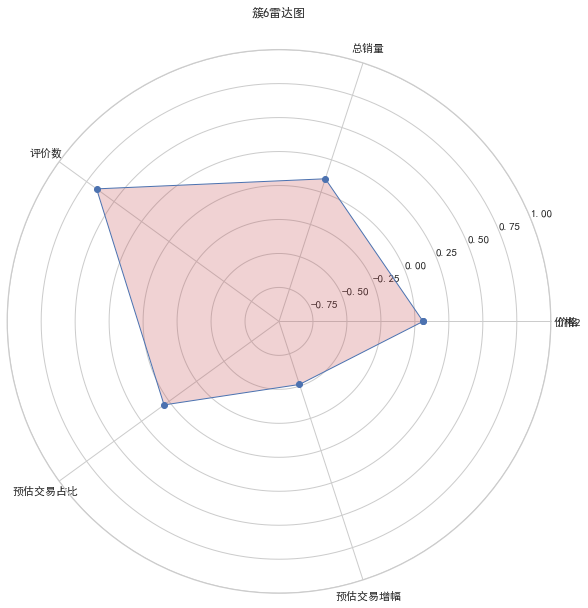

In [56]:
labels = xcen_r.columns
data_lenth = 5

angles = np.linspace(0,2*np.pi,data_lenth,endpoint=False)   # 默认endpoint是true
angles = np.concatenate((angles,np.array([0])))

for i in xcen_r.index:
    plt.figure(figsize=(10,10))
    data_radar = xcen_r.loc[i,:]   # 数据
    plt.polar(angles,data_radar,'bo-',linewidth=1)  # 极坐标系，bo-绘制的是蓝色圆圈实线连接
    plt.thetagrids(angles*180/np.pi,labels)   # 做标签
    plt.fill(angles,data_radar,facecolor='r',alpha=0.25)   # 填充
    plt.ylim(-1,1)   # 设置极轴的范围
    plt.title('簇{0}雷达图'.format(i))
    plt.show()
    # 这里的负值只是代表缩放后处于整体较低水平，并不一定实际增幅是负的。

In [57]:
x

,价格,总销量,评价数,预估交易占比,预估交易增幅,labels
24,0.095652,1.000000,0.636364,1.000000,-0.213806,3
25,0.063768,0.117241,0.909091,0.050044,-0.344237,6
32,0.000000,0.151724,1.000000,0.109087,4.190874,2
35,0.101449,0.451724,0.454545,0.414838,-0.322995,1
36,0.063768,0.093103,0.818182,0.140123,0.360434,5
38,0.231884,0.244828,0.545455,0.383670,-0.346675,1
39,0.243478,0.162069,0.090909,0.397015,-0.468487,1
41,0.078261,0.048276,0.636364,0.059877,0.547916,5
43,0.231884,0.179310,0.454545,0.338235,-0.257500,1
47,0.231884,0.072414,0.090909,0.126207,-0.158372,1


In [58]:
x.groupby('labels').count()

,价格,总销量,评价数,预估交易占比,预估交易增幅
labels,,,,,
0,1,1,1,1,1
1,14,14,14,14,14
2,1,1,1,1,1
3,1,1,1,1,1
4,4,4,4,4,4
5,2,2,2,2,2
6,4,4,4,4,4


In [59]:
x.groupby('labels').median()

,价格,总销量,评价数,预估交易占比,预估交易增幅
labels,,,,,
0,0.188406,0.044828,0.090909,0.100966,2.332222
1,0.231884,0.103448,0.181818,0.221795,-0.209063
2,0.000000,0.151724,1.000000,0.109087,4.190874
3,0.095652,1.000000,0.636364,1.000000,-0.213806
4,0.939130,0.008621,0.045455,0.025022,-0.492929
5,0.071014,0.070690,0.727273,0.100000,0.454175
6,0.071014,0.094828,0.727273,0.039991,-0.547450


In [60]:
x.groupby('labels').sum()

,价格,总销量,评价数,预估交易占比,预估交易增幅
labels,,,,,
0,0.188406,0.044828,0.090909,0.100966,2.332222
1,3.301449,1.813793,3.000000,3.228665,-3.197285
2,0.000000,0.151724,1.000000,0.109087,4.190874
3,0.095652,1.000000,0.636364,1.000000,-0.213806
4,3.643478,0.075862,0.363636,0.155048,-1.971718
5,0.142029,0.141379,1.454545,0.200000,0.908350
6,0.240580,0.413793,2.636364,0.181826,-2.048637


In [61]:
x[x.labels==0]

,价格,总销量,评价数,预估交易占比,预估交易增幅,labels
66,0.188406,0.044828,0.090909,0.100966,2.332222,0


In [62]:
x[x.labels==3]

,价格,总销量,评价数,预估交易占比,预估交易增幅,labels
24,0.095652,1.0,0.636364,1.0,-0.213806,3


In [63]:
x[x.labels==4]

,价格,总销量,评价数,预估交易占比,预估交易增幅,labels
56,0.939130,0.058621,0.272727,0.000000,-0.492929,4
71,0.939130,0.000000,0.000000,0.000000,-0.492929,4
72,1.000000,0.003448,0.090909,0.050044,-0.492929,4
75,0.765217,0.013793,0.000000,0.105004,-0.492929,4


In [64]:
x[x.labels==5]


,价格,总销量,评价数,预估交易占比,预估交易增幅,labels
36,0.063768,0.093103,0.818182,0.140123,0.360434,5
41,0.078261,0.048276,0.636364,0.059877,0.547916,5


In [65]:
x[x.labels==6]

,价格,总销量,评价数,预估交易占比,预估交易增幅,labels
25,0.063768,0.117241,0.909091,0.050044,-0.344237,6
48,0.000000,0.072414,0.727273,0.026119,-0.750662,6
50,0.078261,0.158621,0.272727,0.029939,-0.928126,6
52,0.098551,0.065517,0.727273,0.075724,-0.025611,6


In [66]:
x[(x.labels == 1) |(x.labels == 2)]

,价格,总销量,评价数,预估交易占比,预估交易增幅,labels
32,0.000000,0.151724,1.000000,0.109087,4.190874,2
35,0.101449,0.451724,0.454545,0.414838,-0.322995,1
38,0.231884,0.244828,0.545455,0.383670,-0.346675,1
39,0.243478,0.162069,0.090909,0.397015,-0.468487,1
43,0.231884,0.179310,0.454545,0.338235,-0.257500,1
47,0.231884,0.072414,0.090909,0.126207,-0.158372,1
53,0.231884,0.031034,0.090909,0.060579,-0.195545,1
54,0.188406,0.103448,0.181818,0.206321,-0.123763,1
55,0.188406,0.044828,0.181818,0.096576,0.101839,1
57,0.231884,0.134483,0.181818,0.242318,-0.272015,1


In [67]:
x[(x.labels == 1) + (x.labels == 2)]

D:\Anaconda\lib\site-packages\pandas\core\computation\expressions.py:177: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(


,价格,总销量,评价数,预估交易占比,预估交易增幅,labels
32,0.000000,0.151724,1.000000,0.109087,4.190874,2
35,0.101449,0.451724,0.454545,0.414838,-0.322995,1
38,0.231884,0.244828,0.545455,0.383670,-0.346675,1
39,0.243478,0.162069,0.090909,0.397015,-0.468487,1
43,0.231884,0.179310,0.454545,0.338235,-0.257500,1
47,0.231884,0.072414,0.090909,0.126207,-0.158372,1
53,0.231884,0.031034,0.090909,0.060579,-0.195545,1
54,0.188406,0.103448,0.181818,0.206321,-0.123763,1
55,0.188406,0.044828,0.181818,0.096576,0.101839,1
57,0.231884,0.134483,0.181818,0.242318,-0.272015,1


考虑到专区商品的绝对数都较小，因此仅对特点鲜明的簇进行探究：

簇5中的产品价格较高，其销量和交易占比都维持在较低水平，市场对其反应冷淡。其原因可能是定价超过大众对专区中同类商品的心里预期价格，导致购买欲望消解；也可能是本身不太符合专区的定位。如有可能，建议观察用户在相关页面上的行为数据进行甄别（跳失率居高不下，停留时间也很短/跳失率高但停留时间适当/访问数据几乎没有）。如的确如此，建议转到正常商品区售卖。

簇3中的产品表现平平，预估增幅相较其他水平而言较低，观察发现其原因并非是趋于稳定增长阶段，而是其簇内商品数较多，部分商品系口味sku拆解而成的单品（考虑到一些风险，这些数据已经处理，可能看不出来），导致数据表现并不是那么合适。由于我没接触过专区商品，无法确定是否是技术或者规则限制导致必须这样拆分。因此不做过多评论。

簇4中的产品较其他产品而言表现出色。观察发现其系已成熟的商品的小规格包装，业已经受住市场考验。店铺上架该规格商品的目的可能是为了满足顾客凑单需求或者给已成熟商品引流。建议追加订单数据查看凑单效果，或是追加经由该业面广告渠道下平均访问深度查看是否达到引流效果。

簇0簇6中的产品似乎能够赢得更多的用户反馈。簇6从目前数据看来，销量增长趋势较好，但由于没有上架时间，且绝对数较低，实际市场反馈究竟是否如销量增长趋势，还有待探究。建议根据上架时长、页面流量等数据研究其作为专区主打商品的可行性。

需要注意的是，簇0中商品销量出现负增长是，可能是曝光率减小的原因，也可能是本身导入期销量不稳定，还有可能是店铺商品结构存在问题，存在同类竞品挤压该簇商品(比如离群点中的JD与簇0的JD，簇0的DBD和簇6的DBD。不是很理解为什么要把sku当作spu)。


# 非专区商品结构研究

由于非专区（常规商品）中大多是成熟的商品,因此考虑区分新老产品，通过产品生命周期理论（描述发展趋势）与波士顿矩阵（描述发展情况）直接进行分析。

由于该店将SPU下的SKU拆成了不同的单品，拉低了销售增幅和交易占比的均值线，所以有些数据显得失真

In [68]:
changgui = data[data.专区==0]

In [70]:
changgui.head()

,名称,价格,总销量,评价数,MTD,预估月销量,6月销量,预估交易增幅,预估交易金额,预估交易占比,专区
0,常态0,15.9,77424,18225,2365,3666,3814,-0.038804,58289.4,0.038265,0
1,常态1,19.9,122747,29459,1061,1645,1627,0.011063,32735.5,0.021490,0
2,常态2,29.9,21851,5214,1672,2592,2607,-0.005754,77500.8,0.050877,0
3,常态3,16.9,19012,4155,4185,6487,3413,0.900674,109630.3,0.071969,0
4,常态4,19.9,669466,115547,10000,15500,17976,-0.137739,308450.0,0.202488,0


In [71]:
# 创建一个字段来记录波士顿矩阵分析结果
changgui['level'] = 0

<ipython-input-71-2b4a163b8423>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  changgui['level'] = 0


In [72]:
changgui.head()

,名称,价格,总销量,评价数,MTD,预估月销量,6月销量,预估交易增幅,预估交易金额,预估交易占比,专区,level
0,常态0,15.9,77424,18225,2365,3666,3814,-0.038804,58289.4,0.038265,0,0
1,常态1,19.9,122747,29459,1061,1645,1627,0.011063,32735.5,0.021490,0,0
2,常态2,29.9,21851,5214,1672,2592,2607,-0.005754,77500.8,0.050877,0,0
3,常态3,16.9,19012,4155,4185,6487,3413,0.900674,109630.3,0.071969,0,0
4,常态4,19.9,669466,115547,10000,15500,17976,-0.137739,308450.0,0.202488,0,0


## 波士顿矩阵分析探究商品结构

In [73]:
mean_cg_jyzf,mean_cg_jyzb = changgui.预估交易增幅.mean(),changgui.预估交易占比.mean()

In [74]:
mean_cg_jyzb

0.02025631214130349

In [75]:
mean_cg_jyzf

0.0352743160367516

### 常规爆款

In [77]:
changgui[(changgui.预估交易增幅>mean_cg_jyzf) & (changgui.预估交易占比>mean_cg_jyzb)].sum()

名称        常态3常态7常态10ZAM推荐常态12常态16
价格                          135.5
总销量                        181982
评价数                         24954
MTD                         16231
预估月销量                       25158
6月销量                        17295
预估交易增幅                    1.74485
预估交易金额                     666331
预估交易占比                   0.437427
专区                              0
level                           0
dtype: object

我们发现，标的店铺存在五款爆款商品，共占店铺交易金额的43.74%

其中，以ZAM推荐最为亮眼，上架仅两月（因为6月销量与总销量等同，推定是6月上架）即有出色表现，达到68.0868%增速，并占据7月预估交易金额的21.2969%。这无疑给新品运营提供了一个新的可能——但我们同样应该认识到，该款产品的良好表现可能并不会持久。

该产品可能带来的信息有：

结合流量质量数据，判断该爆款生成的原因是得到了大量曝光，还是得到了非常态化的高质量流量，抑或是二者兼有。
得到大量曝光——在推动潜力款成长为爆款时，我们可能要考虑如何提高曝光率。
得到非常态化的高质量流量——我们可能要考虑在非常态化流量消退前，如何将常规用户也拉入局中(秒杀活动、抢兑活动)，或是将这些非常态化流量纳入常规商品中（专属套餐卷、捆绑卷、“专属”优惠码。比如引向火鸡面）。
结合竞争对手同质产品的相关数据和活动情况，使用假设检验（匹配样本的t检验），判断该爆款对应的营销活动对竞争对手的影响。
综上，我们应该认识到，ZAM推荐常态12这一爆款，可能会很快回归常态（事实上，在数据采集后的第七天，该商品的MTD比预期少了20%。当然也很可能是我估计方法有问题，或是存在其他混淆因素
）。建议侧重于思考 如何利用现有情况，使之在进入常态时仍能保持较好势头（收集用户反馈，进一步优化产品，或者优化产品的购物体验，或者让客户感觉到你在优化产品或者优化购物体验......主要以提高用户对品牌/产品的认同度为核心。以RFM模型来看，可能要致力于推动新流量带来的这部分保值会员/偶然会员的晋级）。

与ZAM推荐相反的是，常态3和常态16是常态化产品爆款的典型。
事实上，常态3和常态16是同一产品的不同口味（不同sku）拆分成的单品。常态3应是常态16以及相关系列（没错，该商品的sku拆成了好几个单品）中，最近推出的口味。
可以预见的是，常态16是已经处于成熟期。建议对其的运营工作以巩固市场、维持现有增速和占比为主，其次是为再激活或者引入新的口味做准备。无疑，常态3就是一个很好的例子。

常态7（干脆面）和常态10相较其他爆款而言，虽然保持一定的增长，但其绝对数变化不大，而且交易占比不高，可能离衰弱期已经不远。当务之急是评估其再激活的可能性、效果与成本。如有可能，试着减缓其迈入衰弱期的速度，

In [79]:
baokuan = changgui[(changgui.预估交易增幅 > mean_cg_jyzf)&(changgui.预估交易占比>mean_cg_jyzb)]

In [80]:
baokuan['level'] = 1

<ipython-input-80-5ec812f6244a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baokuan['level'] = 1


In [81]:
baokuan

,名称,价格,总销量,评价数,MTD,预估月销量,6月销量,预估交易增幅,预估交易金额,预估交易占比,专区,level
3,常态3,16.9,19012,4155,4185,6487,3413,0.900674,109630.3,0.071969,0,1
7,常态7,28.9,63089,8122,1008,1562,1491,0.047619,45141.8,0.029634,0,1
10,常态10,29.9,53295,6153,696,1079,1015,0.063054,32262.1,0.021179,0,1
12,ZAM推荐常态12,29.9,6455,364,7000,10850,6455,0.680868,324415.0,0.212969,0,1
16,常态16,29.9,40131,6160,3342,5180,4921,0.052632,154882.0,0.101676,0,1


### 老爆款

In [82]:
changgui[(changgui.预估交易增幅 <= mean_cg_jyzf)&(changgui.预估交易占比>mean_cg_jyzb)]

,名称,价格,总销量,评价数,MTD,预估月销量,6月销量,预估交易增幅,预估交易金额,预估交易占比,专区,level
0,常态0,15.9,77424,18225,2365,3666,3814,-0.038804,58289.4,0.038265,0,0
1,常态1,19.9,122747,29459,1061,1645,1627,0.011063,32735.5,0.021490,0,0
2,常态2,29.9,21851,5214,1672,2592,2607,-0.005754,77500.8,0.050877,0,0
4,常态4,19.9,669466,115547,10000,15500,17976,-0.137739,308450.0,0.202488,0,0
5,常态5,33.9,81920,19282,1140,1767,1759,0.004548,59901.3,0.039323,0,0
8,常态8,53.9,25282,4566,712,792,780,0.015115,42688.8,0.028024,0,0
74,常态74,13.9,5470,1099,2790,4325,4736,-0.086782,60117.5,0.039465,0,0


In [83]:
changgui[(changgui.预估交易增幅 <= mean_cg_jyzf)&(changgui.预估交易占比>mean_cg_jyzb)].sum()

名称        常态0常态1常态2常态4常态5常态8常态74
价格                         187.3
总销量                      1004160
评价数                       193392
MTD                        19740
预估月销量                      30287
6月销量                       33299
预估交易增幅                 -0.238353
预估交易金额                    639683
预估交易占比                  0.419934
专区                             0
level                          0
dtype: object

老爆款7种，共占交易金额的41.99%，大多都处于成熟期。

其中常态4业已进入衰退期，销售量发生较大下滑，但由于绝对数基数大、用户群体广泛，其衰退期可能会很长。当务之急是维持甚至提升营销力度，尝试能否延缓衰退，或是将客户有计划地引导至同质的新产品、新口味中；其次考虑能否再激活。由于其体量较大，再激活的成本可能略高。

常态74似乎是上架不久的商品，其销售量发生较大下滑的原因可能是流量的缺失。个人猜测该商品可能是上一次引流活动时的主推产品，从非常态回到常态出现销量缩水可能是正常现象。当然也可能是自家店铺的其他商品分流所致。

In [84]:
laobaokuan = changgui[(changgui.预估交易增幅 <= mean_cg_jyzf)&(changgui.预估交易占比>mean_cg_jyzb)]

In [85]:
laobaokuan['level']=2

<ipython-input-85-80d2211d8e15>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laobaokuan['level']=2


### 潜力款/问题款

In [86]:
changgui[(changgui.预估交易增幅 > mean_cg_jyzf)&(changgui.预估交易占比<= mean_cg_jyzb)]

,名称,价格,总销量,评价数,MTD,预估月销量,6月销量,预估交易增幅,预估交易金额,预估交易占比,专区,level
11,常态11,43.9,460417,34406,403,625,591,0.057530,27437.5,0.018012,0,0
22,常态22,29.9,7554,1683,114,177,167,0.059880,5292.3,0.003474,0,0
26,常态26,29.9,576,97,65,101,96,0.052083,3019.9,0.001982,0,0
30,常态30,18.9,1092,185,49,76,72,0.055556,1436.4,0.000943,0,0
42,常态42,22.8,12,0,14,22,21,0.047619,501.6,0.000329,0,0
46,常态46,29.9,42,13,42,65,62,0.048387,1943.5,0.001276,0,0
64,常态64,59.8,3123,466,9,14,13,0.076923,837.2,0.000550,0,0


In [87]:
changgui[(changgui.预估交易增幅 > mean_cg_jyzf)&(changgui.预估交易占比<= mean_cg_jyzb)].sum()

名称        常态11常态22常态26常态30常态42常态46常态64
价格                               235.1
总销量                             472816
评价数                              36850
MTD                                696
预估月销量                             1080
6月销量                              1022
预估交易增幅                        0.397978
预估交易金额                         40468.4
预估交易占比                       0.0265663
专区                                   0
level                                0
dtype: object

该组商品的数据显得很“怪异”，并不是很符合对潜力款的认知：

常态11 总销量很高，但是其销量绝对数和交易占比金额（别忘了，我们使用月交易占比来代替年交易额占比，我们在开头中说过的）都很低。建议追加相关页面的流量数据，以判断究竟是运营策略问题，还是该产品业已走到生命周期的尽头，还是当下规格不再被市场所认可。（我个人认为可能是第一和第三，因为该产品是同一口味方便面的20连包，而且包装很简陋，评论中许多人也都表露出对简陋包装在运输中被压碎的担忧）

常态22和常态64 则更有可能是营销策略或者自身产品定位的原因,需要追加上架时间加以判断。

常态22和常态64都是拌面
至于常态26、30、42、46，建议追加流量数据探寻是否uv、pv偏低或者转化率偏低

In [88]:
qianlikuan = changgui[(changgui.预估交易增幅 > mean_cg_jyzf)&(changgui.预估交易占比<= mean_cg_jyzb)]

In [89]:
qianlikuan['level']=3

<ipython-input-89-a07501c29309>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qianlikuan['level']=3


### 淘汰款/瘦狗款/导入款

In [90]:
changgui[(changgui.预估交易增幅 <= mean_cg_jyzf)&(changgui.预估交易占比<= mean_cg_jyzb)]

,名称,价格,总销量,评价数,MTD,预估月销量,6月销量,预估交易增幅,预估交易金额,预估交易占比,专区,level
6,常态6,23.9,9243,1638,807,1251,1276,-0.019592,29898.9,0.019628,0,0
9,常态9,29.9,39302,10478,558,865,878,-0.014806,25863.5,0.016979,0,0
13,常态13,19.9,0,8,125,194,0,0.000000,3860.6,0.002534,0,0
14,常态14,29.9,2189,502,383,594,596,-0.003356,17760.6,0.011659,0,0
15,常态15,19.9,3,0,190,295,0,0.000000,5870.5,0.003854,0,0
17,常态17,18.8,9608,1832,0,0,0,0.000000,0.0,0.000000,0,0
18,常态18,15.8,3978,913,328,508,510,-0.003922,8026.4,0.005269,0,0
19,常态19,38.9,8339,1941,186,288,291,-0.010309,11203.2,0.007355,0,0
20,常态20,28.9,4812,993,115,178,179,-0.005587,5144.2,0.003377,0,0
21,常态21,16.9,384,67,199,308,331,-0.069486,5205.2,0.003417,0,0


In [91]:
changgui[(changgui.预估交易增幅 <= mean_cg_jyzf)&(changgui.预估交易占比<= mean_cg_jyzb)].sum()

名称        常态6常态9常态13常态14常态15常态17常态18常态19常态20常态21常态23常态27...
价格                                                   1247.7
总销量                                                  172824
评价数                                                   29498
MTD                                                    3811
预估月销量                                                  5908
6月销量                                                   5497
预估交易增幅                                             -0.17603
预估交易金额                                               165479
预估交易占比                                             0.108632
专区                                                        0
level                                                     0
dtype: object

In [92]:
taotai = changgui[(changgui.预估交易增幅 <= mean_cg_jyzf)&(changgui.预估交易占比<= mean_cg_jyzb)]

In [93]:
taotai[taotai.总销量<=1000]

,名称,价格,总销量,评价数,MTD,预估月销量,6月销量,预估交易增幅,预估交易金额,预估交易占比,专区,level
13,常态13,19.9,0,8,125,194,0,0.000000,3860.6,0.002534,0,0
15,常态15,19.9,3,0,190,295,0,0.000000,5870.5,0.003854,0,0
21,常态21,16.9,384,67,199,308,331,-0.069486,5205.2,0.003417,0,0
23,常态23,19.9,224,47,106,164,174,-0.057471,3263.6,0.002142,0,0
27,常态27,28.9,432,81,111,172,169,0.017751,4970.8,0.003263,0,0
28,常态28,59.9,568,105,108,167,165,0.012121,10003.3,0.006567,0,0
29,常态29,53.8,133,36,51,79,83,-0.048193,4250.2,0.002790,0,0
37,常态37,60.0,488,106,25,39,39,0.000000,2340.0,0.001536,0,0
51,常态51,42.9,154,41,0,0,0,0.000000,0.0,0.000000,0,0
58,常态58,60.0,310,73,13,20,20,0.000000,1200.0,0.000788,0,0


In [94]:
taotai[taotai.总销量<=1000].count()/taotai.count()

名称        0.466667
价格        0.466667
总销量       0.466667
评价数       0.466667
MTD       0.466667
预估月销量     0.466667
6月销量      0.466667
预估交易增幅    0.466667
预估交易金额    0.466667
预估交易占比    0.466667
专区        0.466667
level     0.466667
dtype: float64

发现淘汰款中，约有46.67%的商品均是未能成功打响或正在处于导入期的新产品。在成本允许的情况下，对于这些新品，我们可以适当的制定一些营销活动。

建议追加上架时间，以甄别究竟是失败的产品还是仍处在导入期的新产品。并对失败的产品开展专项研究，总结其失败的原因

In [95]:
taotai['level']=4

<ipython-input-95-79cd5bf19c85>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taotai['level']=4


综上，忽略一些细节，该店在销售维度下的商品结构还是很合理的。


In [96]:
boston = pd.concat([baokuan,laobaokuan,qianlikuan,taotai])

In [97]:
boston

,名称,价格,总销量,评价数,MTD,预估月销量,6月销量,预估交易增幅,预估交易金额,预估交易占比,专区,level
3,常态3,16.9,19012,4155,4185,6487,3413,0.900674,109630.3,0.071969,0,1
7,常态7,28.9,63089,8122,1008,1562,1491,0.047619,45141.8,0.029634,0,1
10,常态10,29.9,53295,6153,696,1079,1015,0.063054,32262.1,0.021179,0,1
12,ZAM推荐常态12,29.9,6455,364,7000,10850,6455,0.680868,324415.0,0.212969,0,1
16,常态16,29.9,40131,6160,3342,5180,4921,0.052632,154882.0,0.101676,0,1
0,常态0,15.9,77424,18225,2365,3666,3814,-0.038804,58289.4,0.038265,0,2
1,常态1,19.9,122747,29459,1061,1645,1627,0.011063,32735.5,0.021490,0,2
2,常态2,29.9,21851,5214,1672,2592,2607,-0.005754,77500.8,0.050877,0,2
4,常态4,19.9,669466,115547,10000,15500,17976,-0.137739,308450.0,0.202488,0,2
5,常态5,33.9,81920,19282,1140,1767,1759,0.004548,59901.3,0.039323,0,2


In [98]:
bst = boston.copy()

In [100]:
# np.inf 正无穷 ，-np.inf 负无穷
bins = [-np.inf,10,20,30,40,50,60,70,80,90,100,np.inf]
bst['价格'] = pd.cut(bst.价格,bins=bins)

In [101]:
bst

,名称,价格,总销量,评价数,MTD,预估月销量,6月销量,预估交易增幅,预估交易金额,预估交易占比,专区,level
3,常态3,"(10.0, 20.0]",19012,4155,4185,6487,3413,0.900674,109630.3,0.071969,0,1
7,常态7,"(20.0, 30.0]",63089,8122,1008,1562,1491,0.047619,45141.8,0.029634,0,1
10,常态10,"(20.0, 30.0]",53295,6153,696,1079,1015,0.063054,32262.1,0.021179,0,1
12,ZAM推荐常态12,"(20.0, 30.0]",6455,364,7000,10850,6455,0.680868,324415.0,0.212969,0,1
16,常态16,"(20.0, 30.0]",40131,6160,3342,5180,4921,0.052632,154882.0,0.101676,0,1
0,常态0,"(10.0, 20.0]",77424,18225,2365,3666,3814,-0.038804,58289.4,0.038265,0,2
1,常态1,"(10.0, 20.0]",122747,29459,1061,1645,1627,0.011063,32735.5,0.021490,0,2
2,常态2,"(20.0, 30.0]",21851,5214,1672,2592,2607,-0.005754,77500.8,0.050877,0,2
4,常态4,"(10.0, 20.0]",669466,115547,10000,15500,17976,-0.137739,308450.0,0.202488,0,2
5,常态5,"(30.0, 40.0]",81920,19282,1140,1767,1759,0.004548,59901.3,0.039323,0,2


In [104]:
bst['价格'].value_counts()

(20.0, 30.0]     18
(10.0, 20.0]     13
(50.0, 60.0]     10
(30.0, 40.0]      4
(40.0, 50.0]      2
(100.0, inf]      1
(60.0, 70.0]      1
(90.0, 100.0]     0
(80.0, 90.0]      0
(70.0, 80.0]      0
(-inf, 10.0]      0
Name: 价格, dtype: int64

In [115]:
bst_1 = bst.groupby(['价格','level']).agg({'名称':'count','总销量':'sum','预估月销量':'sum','预估交易增幅':'mean','预估交易占比':'sum'}).dropna()

In [116]:
bst_1

名称       总销量    预估月销量    预估交易增幅    预估交易占比
价格           level                                           
(10.0, 20.0] 1       1   19012.0   6487.0  0.900674  0.071969
             2       4  875107.0  25136.0 -0.063066  0.301709
             3       1    1092.0     76.0  0.055556  0.000943
             4       7   24650.0   1593.0 -0.016355  0.018755
(20.0, 30.0] 1       4  162970.0  18671.0  0.211043  0.365458
             2       1   21851.0   2592.0 -0.005754  0.050877
             3       4    8184.0    365.0  0.051992  0.007062
             4       9  100567.0   3508.0 -0.008356  0.062870
(30.0, 40.0] 2       1   81920.0   1767.0  0.004548  0.039323
             4       3   39813.0    339.0  0.004500  0.008688
(40.0, 50.0] 3       1  460417.0    625.0  0.057530  0.018012
             4       1     154.0      0.0  0.000000  0.000000
(50.0, 60.0] 2       1   25282.0    792.0  0.015115  0.028024
             3       1    3123.0     14.0  0.076923  0.000550
             4       8    5334.0    421.0 -0.002697  0.016163
(60.0, 70.0] 4       1    2006.0     47.0  0.021739  0.002157
(100.0, inf] 4       1     300.0      0.0  0.000000  0.000000

In [117]:
bst_price = bst.groupby(['价格']).agg({'名称':'count',
                                 '总销量':'sum',
                                 '预估月销量':'sum',
                                 '预估交易增幅':'mean',
                                '预估交易占比':'sum'}
                       ).dropna().sort_values(by = '预估交易占比',ascending = False)

In [118]:
bst_price

,名称,总销量,预估月销量,预估交易增幅,预估交易占比
价格,,,,,
"(20.0, 30.0]",18,293572,25136,0.053955,0.486267
"(10.0, 20.0]",13,919861,33292,0.045345,0.393376
"(30.0, 40.0]",4,121733,2106,0.004512,0.048011
"(50.0, 60.0]",10,33739,1227,0.007046,0.044737
"(40.0, 50.0]",2,460571,625,0.028765,0.018012
"(60.0, 70.0]",1,2006,47,0.021739,0.002157
"(100.0, inf]",1,300,0,0.000000,0.000000


In [121]:
bst_1['单均交易占比'] = bst_1.预估交易占比/bst_1.名称
bst_1

名称       总销量    预估月销量    预估交易增幅    预估交易占比    单均交易占比
价格           level                                                     
(10.0, 20.0] 1       1   19012.0   6487.0  0.900674  0.071969  0.071969
             2       4  875107.0  25136.0 -0.063066  0.301709  0.075427
             3       1    1092.0     76.0  0.055556  0.000943  0.000943
             4       7   24650.0   1593.0 -0.016355  0.018755  0.002679
(20.0, 30.0] 1       4  162970.0  18671.0  0.211043  0.365458  0.091365
             2       1   21851.0   2592.0 -0.005754  0.050877  0.050877
             3       4    8184.0    365.0  0.051992  0.007062  0.001765
             4       9  100567.0   3508.0 -0.008356  0.062870  0.006986
(30.0, 40.0] 2       1   81920.0   1767.0  0.004548  0.039323  0.039323
             4       3   39813.0    339.0  0.004500  0.008688  0.002896
(40.0, 50.0] 3       1  460417.0    625.0  0.057530  0.018012  0.018012
             4       1     154.0      0.0  0.000000  0.000000  0.000000
(50.0, 60.0] 2       1   25282.0    792.0  0.015115  0.028024  0.028024
             3       1    3123.0     14.0  0.076923  0.000550  0.000550
             4       8    5334.0    421.0 -0.002697  0.016163  0.002020
(60.0, 70.0] 4       1    2006.0     47.0  0.021739  0.002157  0.002157
(100.0, inf] 4       1     300.0      0.0  0.000000  0.000000  0.000000

从价格段来看，该店铺的销售额约有30.17%来自（10，20]区间内的4款老爆款商品，约有36.54%来自（20，30]区间内的4款爆款商品。

其中，来自（10，20]区间内的4款老爆款商品的交易增幅正在减小，考虑维持营销力度延缓其下降趋势（与前面波士顿矩阵分析印证）；

来自（20，30]区间内的4款爆款商品交易增幅仍然较高，考虑进行专项分析深挖其潜力（见前面）。

从单品平均交易占比（实际上是单品平均销售额）来看，在满足用户需求的前提下，部分价格段-生长周期下的商品可以考虑精简。不过已知该店存在sku拆分当单品的情况下，其实可以考虑合并回来——这点不一定对营销上有帮助，但可能会有助于用户的购物体验：不同口味通过在同一个网页中选中不同sku来切换，与点击不同的网址是两种用户体验，尤其是后者有六七个网址的情况下。至于业务中谁更合适，可能需要类似ABtest或者对比下历史数据。